In [1]:
import simulated_bifurcation as sb
import torch
from itertools import combinations
import numpy as np
import numpy.testing as npt
import sympy
from sympy import symbols, QQ
import re
import warnings
# warnings.filterwarnings("error")

In [2]:
def preprocess(model, gens):
    """
    Establish the correct/allowed model symbols (gens) and update the model accordingly
    """
    if gens is None:
        gens = []
        for gen in model.ring.gens:
            if re.match('x[1-9][0-9]*', str(gen)):
                gens.append(gen)
            # elif re.match('x0$', str(gen)):
            #     pass                
        gens = tuple(gens)

    drop_gens = set(model.ring.gens).difference(set(gens))
    for gen in drop_gens:
        warnings.warn(f'Symbol "{str(gen)}" was dropped from the model')
        model = model.drop(model.ring(gen))

    return model, gens

def split_constant_term(model, gens):
    """
    Separate the constant term from the polynomial expression
    """
    model_dict = model.to_dict()
    constant_monom = (0,) * len(gens)
    constant = model_dict.pop(constant_monom, None)
    if constant is None:
        constant = 0
    else:
        constant = float(constant)
        if constant.is_integer():
            constant = int(constant)

    return model.ring(model_dict), constant


def square_diagonal_terms(model, gens):
    """
    Convert linear terms, $x_i$, to squared terms, $x_i*x_i$ 
    """
    tmp_monom = [0,] * len(gens)
    squared_dict = model.to_dict().copy()
    for i, gen in enumerate(gens):
        tmp_monom[i] = 1
        coeff = squared_dict.pop(tuple(tmp_monom), None)
        tmp_monom[i] = 2
        if coeff is not None:
            squared_dict[tuple(tmp_monom)] = squared_dict.get(tuple(tmp_monom), 0) + coeff
        tmp_monom[i] = 0

    return model.ring(squared_dict)


def poly_to_Q(model, gens=None):
    """
    Convert a `sympy` PolyElement model to its corresponding Q matrix and constant
    """

    model, gens = preprocess(model, gens)
    model, constant = split_constant_term(model, gens)
    model = square_diagonal_terms(model, gens)

    Q = torch.zeros((len(gens), len(gens)), dtype=torch.float64)
    monoms = torch.tensor(model.monoms(), dtype=torch.int32)
    coeffs = torch.tensor(model.coeffs(), dtype=torch.float64)
    for i in range(len(monoms)):
        idx = torch.nonzero(monoms[i])
        if len(idx) == 2:
            value = 0.5*coeffs[i]
            Q[idx[0], idx[1]] = value
            Q[idx[1], idx[0]] = value
        elif len(idx) == 1:
            Q[idx[0], idx[0]] = coeffs[i]
        else:
            warnings.warn(f'Unrecognized non-quadratic terms were excluded from the model')
    
    return Q, constant

# Modeling Common Combinatorial Optimization Problems as Ising Models

Here, we use simulated bifurcation to minimize the Hamiltonian that is represented by our Ising model

$$H(\textbf{s}=(s_{1},s_{2},...,s_{n})) = \sum_{i \in V} h_{i}s_{i} + \sum_{\{ij\} \in E} j_{ij}s_{i}s_{j},\;\;\; s_{i}=\pm1$$

# Number Partition

[See this blog](https://medium.com/arnaldo-gunzi-quantum/interpretation-of-the-numerical-partition-problem-using-the-ising-model-c90e4edf5754)

Given a set of numbers, `S = [9, 6, 5, 1, 4, 9, 12, 5, 2, 15]`, is there a partition into two distinct sets R and S-R, so that the sum of the elements is the same?

In [3]:
S = torch.tensor([9, 6, 5, 1, 4, 9, 12, 5, 2, 15]).unsqueeze(1)
matrix = S @ S.t()

In [4]:
matrix

tensor([[ 81,  54,  45,   9,  36,  81, 108,  45,  18, 135],
        [ 54,  36,  30,   6,  24,  54,  72,  30,  12,  90],
        [ 45,  30,  25,   5,  20,  45,  60,  25,  10,  75],
        [  9,   6,   5,   1,   4,   9,  12,   5,   2,  15],
        [ 36,  24,  20,   4,  16,  36,  48,  20,   8,  60],
        [ 81,  54,  45,   9,  36,  81, 108,  45,  18, 135],
        [108,  72,  60,  12,  48, 108, 144,  60,  24, 180],
        [ 45,  30,  25,   5,  20,  45,  60,  25,  10,  75],
        [ 18,  12,  10,   2,   8,  18,  24,  10,   4,  30],
        [135,  90,  75,  15,  60, 135, 180,  75,  30, 225]])

In [5]:
spins, energy = sb.minimize(matrix, input_type='spin', ballistic=True)
mask = spins == 1
groups = (S[mask], S[~mask])

Bifurcated agents: 100%|█████████████████████| 128/128 [00:00<00:00, 996.27it/s]


In [6]:
groups, spins, energy

((tensor([[ 5],
          [ 1],
          [ 9],
          [12],
          [ 5],
          [ 2]]),
  tensor([[ 9],
          [ 6],
          [ 4],
          [15]])),
 tensor([-1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.]),
 0.0)

# Graph Partition

[See this blog](https://medium.com/arnaldo-gunzi-quantum/example-of-the-problem-of-graph-partitioning-using-the-ising-model-14a149074264)

Imagine that you have 4 vertices, `V = ["A", "B", "C", "D"]`, with some edges between them. Is there a way to divide the 4 vertices into 2 groups so that there are an even number of vertices in each group while breaking as few edges as possible?

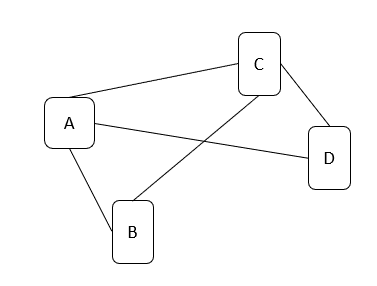

One solution might be:

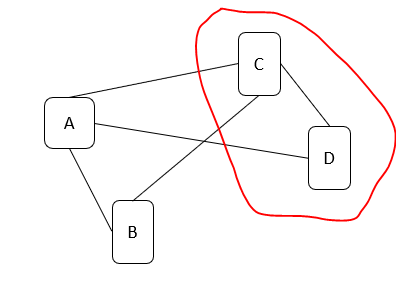

This results in 3 broken edges. Alternatively, we can do:

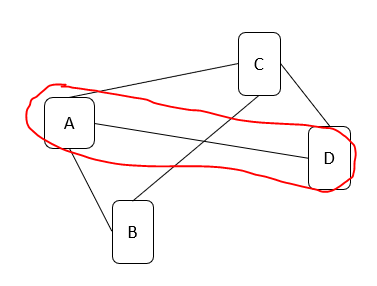

and this also breaks 3 edges too (the BC, despite crossing the drawing, is not broken. It is as if it were on another plane!).

$$H = H_A + H_B$$
$$H = A(\sum_{i=1}^{N}s_i)^2  + H_B$$
$$H = A(\sum_{i=1}^{N}s_i)(\sum_{i=1}^{N}s_i) + H_B$$
$$H = A(s^T\mathbb{1})(\mathbb{1}^Ts) + H_B$$
$$H = As^T(\mathbb{1}\mathbb{1}^T)s + H_B$$
$$H = s^T(A\mathbb{1}\mathbb{1}^T)s + H_B$$
$$H = s^TAs + H_B$$
$$H = s^TAs + B\sum_{(uv) \in E}\frac{1-s_{u}s_{v}}{2}$$
$$H = s^TAs + \frac{B}{2}\sum_{(uv) \in E}1-s_{u}s_{v}$$
$$H = s^TAs + \frac{B}{2}\sum_{(uv) \in E}1-\frac{B}{2}\sum_{(uv) \in E}s_{u}s_{v}$$
$$H = s^TAs + \frac{B}{2}\sum_{(uv) \in E}1-\frac{B}{2}\sum_{u=1}^{N}\sum_{v=1}^{N}G_{u,v}s_{u}s_{v}$$
$$H = s^TAs + \frac{B}{2}\sum_{(uv) \in E}1-\frac{B}{2}\sum_{u=1}^{N}s_{u}\sum_{v=1}^{N}G_{u,v}s_{v}$$
$$H = s^TAs + \frac{B}{2}\sum_{(uv) \in E}1-\frac{B}{2}s^TGs$$

Note that $\frac{B}{2}\sum_{(uv) \in E}1$ is constant and can be omitted since minimizing a constant is pointless since it will be zero.

In [7]:
A = 1
B = 1
matrix = A * torch.ones((4,4)) - (B/2) *torch.tensor([[0, 1, 1, 1],
                                                      [1, 0, 1, 0],
                                                      [1, 1, 0, 1],
                                                      [1, 0, 1, 0]])
matrix

tensor([[1.0000, 0.5000, 0.5000, 0.5000],
        [0.5000, 1.0000, 0.5000, 1.0000],
        [0.5000, 0.5000, 1.0000, 0.5000],
        [0.5000, 1.0000, 0.5000, 1.0000]])

In [8]:
spins, energy = sb.minimize(matrix, input_type='spin', ballistic=True)

Bifurcated agents: 100%|████████████████████| 128/128 [00:00<00:00, 1673.16it/s]


In [9]:
spins, energy

(tensor([ 1.,  1., -1., -1.]), 1.0)

# Binary Integer Linear Programming

# QUBO

[See section 2 of this paper](https://arxiv.org/pdf/1811.11538.pdf)

Minimize $y=-5x_1-3x_2-8x_3-6x_4+4x_1x_2+8x_1x_3+2x_2x_3+10x_3x_4$

Translated to sympy, we get:

In [10]:
x = symbols('x(:5)')
x

(x0, x1, x2, x3, x4)

In [11]:
# polynomial ring of symbolic coefficients
R = QQ[x[1:]]

In [12]:
model = R(-5*x[1]
             -3*x[2]
             -8*x[3]
             -6*x[4]
             +4*x[1]*x[2]
             +8*x[1]*x[3]
             +2*x[2]*x[3]
             +10*x[3]*x[4]
            )
model

4*x1*x2 + 8*x1*x3 - 5*x1 + 2*x2*x3 - 3*x2 + 10*x3*x4 - 8*x3 - 6*x4

In [13]:
Q, constant = poly_to_Q(model)
Q

tensor([[-5.,  2.,  4.,  0.],
        [ 2., -3.,  1.,  0.],
        [ 4.,  1., -8.,  5.],
        [ 0.,  0.,  5., -6.]], dtype=torch.float64)

In [14]:
spins, energy = sb.minimize(Q, input_type='binary', ballistic=True)
spins, energy

Bifurcated agents: 100%|████████████████████| 128/128 [00:00<00:00, 1846.85it/s]


(tensor([1., 0., 0., 1.]), -11.0)

# The Number Partitioning Problem

[See section 3.1](https://arxiv.org/pdf/1811.11538.pdf)

$$\text{diff}^2=\{ c-2\sum_{j=1}^{m}s_jx_j \}^2,\;\; \text{where } c=\sum_{j=1}^m s_j$$
$$\text{diff}^2=c^2 - 4c\sum_{j=1}^{m}s_jx_j + \left(2\sum_{j=1}^{m}s_jx_j\right)^2 $$
$$\text{diff}^2=c^2 -4c\sum_{j=1}^{m}s_jx_j + 4\left(\sum_{j=1}^{m}s_jx_j\right)^2 $$
$$\text{diff}^2=c^2 -4\left( c\sum_{j=1}^{m}s_jx_j + \left(\sum_{j=1}^{m}s_jx_j\right)^2\right)$$
$$\text{diff}^2=c^2 +4\left( \left(\sum_{j=1}^{m}s_jx_j\right)^2 - c\sum_{j=1}^{m}s_jx_j \right)$$
$$\text{diff}^2=c^2 +4\left( \left(\sum_{j=1}^{m}s_jx_j\right)\left(\sum_{j=1}^{m}s_jx_j\right) - c\sum_{j=1}^{m}s_jx_j \right)$$
$$\text{diff}^2=c^2 +4\left( \left(\sum_{j=1}^{m}s_j^2x_j^2\right)+\left(\sum_{\text{cyc}, k \neq l}^{m}s_kx_ks_lx_l\right) - c\sum_{j=1}^{m}s_jx_j \right)$$
$$\text{diff}^2=c^2 +4\left( \sum_{j=1}^{m}s_j^2x_j^2 - c\sum_{j=1}^{m}s_jx_j  + \sum_{\text{cyc}, k \neq l}^{m}s_kx_ks_lx_l\right) $$
$$\text{diff}^2=c^2 +4\left( \sum_{j=1}^{m}s_j^2x_j^2 - c\sum_{j=1}^{m}s_jx_j^2  + \sum_{\text{cyc}, k \neq l}^{m}s_kx_ks_lx_l\right), \;\; \because x_j=x_j^2 \;\; \text{(See bullet 2. in Section 2)}$$
$$\text{diff}^2=c^2 +4\left( \sum_{j=1}^{m}s_jx_j^2\left( s_j - c \right) + \sum_{\text{cyc}, k \neq l}^{m}s_kx_ks_lx_l\right) $$
$$\text{diff}^2=c^2 +4\left( \sum_{j=1}^{m}s_jx_j\left( s_j - c \right)x_j + \sum_{\text{cyc}, k \neq l}^{m}s_kx_ks_lx_l\right) $$
$$\text{diff}^2=c^2 +4\left( \sum_{j=1}^{m}x_js_j\left( s_j - c \right)x_j + \sum_{\text{cyc}, k \neq l}^{m}x_ks_ks_lx_l\right) $$
$$\text{diff}^2=c^2 +4x^TQx $$
$$\text{where the diagonal elements of }Q\;\text{are}\;\; q_{ii}=s_i(s_i-c),\;\;$$
$$\text{and the off-diagonal elements of }Q\;\text{are}\;\; q_{ij}=s_is_j$$

Dropping the additive and multiplicative constants, our QUBO optimization problem becomes:

$$\text{QUBO: min } y=x^tQx$$

# Numerical Example

Consider the set of eight numbers

$$S=\{25,7,13,31,42,17,21,10\}$$

In [15]:
S = torch.tensor([25,7,13,31,42,17,21,10]).unsqueeze(1)
c = torch.sum(S)
Q = S @ S.t()
Q[range(len(S)), range(len(S))]=(S * (S - c)).squeeze()  # Fill diagonal
Q

tensor([[-3525,   175,   325,   775,  1050,   425,   525,   250],
        [  175, -1113,    91,   217,   294,   119,   147,    70],
        [  325,    91, -1989,   403,   546,   221,   273,   130],
        [  775,   217,   403, -4185,  1302,   527,   651,   310],
        [ 1050,   294,   546,  1302, -5208,   714,   882,   420],
        [  425,   119,   221,   527,   714, -2533,   357,   170],
        [  525,   147,   273,   651,   882,   357, -3045,   210],
        [  250,    70,   130,   310,   420,   170,   210, -1560]])

In [16]:
spins, energy = sb.minimize(Q, input_type='binary', ballistic=True)
spins, energy

Bifurcated agents: 100%|████████████████████| 128/128 [00:00<00:00, 1395.49it/s]


(tensor([0., 1., 1., 0., 1., 0., 1., 0.]), -6889.0)

# The Max-Cut Problem

[See section 3.2](https://arxiv.org/pdf/1811.11538.pdf)

The problem of maximizing the number of edges in the cut can be formulated as:

$$\text{Maximize }y=\sum_{(i,j) \in E}\left( x_i+x_j-2x_ix_j\right) $$

which is an instance of

$$\text{QUBO: max }y=x^tQx$$

The linear terms determine the elements of the main diagonal of $Q$ and the quadratic terms determine the off-diagonal elements.

# Numerical Example

Consider the following undirected graph with 5 vertices and 6 edges:

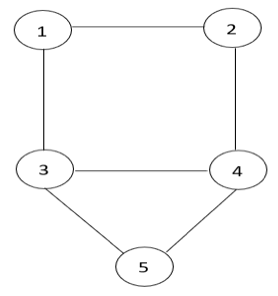

Explicitly taking account all of the edges in the graph gives the following formulation:

$$\begin{align}
\text{Maximize }y=\left(x_1+x_2-2x_1x_2 \right) + \\
\left( x_1+x_3-2x_1x_3 \right) + \\
\left( x_2+x_4-2x_2x_4 \right) + \\
\left( x_3+x_4-2x_3x_4 \right) + \\
\left( x_3+x_5-2x_3x_5 \right) + \\
\left( x_4+x_5-2x_4x_5\right)
\end{align}
$$

or

$$\text{max }y=2x_1+2x_2+3x_3+3x_4+2x_5-2x_1x_2-2x_1x_3-2x_2x_4-2x_3x_4-2x_3x_5-2x_4x_5$$
$$\text{max }y=2x_1^2+2x_2^2+3x_3^2+3x_4^2+2x_5^2-2x_1x_2-2x_1x_3-2x_2x_4-2x_3x_4-2x_3x_5-2x_4x_5,\;\;\;\because x_i=x_i^2$$

Translating to sympy gives:

In [17]:
x = symbols('x(:6)')
x

(x0, x1, x2, x3, x4, x5)

In [18]:
# polynomial ring of symbolic coefficients
R = QQ[x[1:]]

In [19]:
model = R(x[1]+x[2]-2*x[1]*x[2]
             +x[1]+x[3]-2*x[1]*x[3]
             +x[2]+x[4]-2*x[2]*x[4]
             +x[3]+x[4]-2*x[3]*x[4]
             +x[3]+x[5]-2*x[3]*x[5]
             +x[4]+x[5]-2*x[4]*x[5]
            )
model

-2*x1*x2 - 2*x1*x3 + 2*x1 - 2*x2*x4 + 2*x2 - 2*x3*x4 - 2*x3*x5 + 3*x3 - 2*x4*x5 + 3*x4 + 2*x5

In [20]:
Q, constant = poly_to_Q(model)
Q

tensor([[ 2., -1., -1.,  0.,  0.],
        [-1.,  2.,  0., -1.,  0.],
        [-1.,  0.,  3., -1., -1.],
        [ 0., -1., -1.,  3., -1.],
        [ 0.,  0., -1., -1.,  2.]], dtype=torch.float64)

In [21]:
spins, energy = sb.maximize(Q, input_type='binary', ballistic=True)
spins, energy

Bifurcated agents: 100%|████████████████████| 128/128 [00:00<00:00, 1337.72it/s]


(tensor([1., 0., 0., 1., 0.]), 5.0)

# Creating QUBO Models Using Known Penalties

|   | Classical Constraints | Equivalent Penalty     | Description                     |
|---|-----------------------|------------------------|---------------------------------|
| 1 | $x_i+x_j \le 1$       | $P\left(x_ix_j\right)$ | Either $x_i$ OR $x_j$ or neither, not both |
| 2 | $x_i+x_j \ge 1$       | $P\left(1-x_i-x_j+x_ix_j\right)$ | At least one of $x_i$ OR $x_j$ |
| 3 | $x_i+x_j = 1$       | $P\left(1-x_i-x_j+2x_ix_j\right)$ | Exactly only one of $x_i$ OR $x_j$ |
| 4 | $x_i \le x_j$       | $P\left(x_i-x_ix_j\right)$ |  |
| 5 | $x_i + x_j + x_k \le 1$       | $P\left(x_ix_j+x_ix_k+x_jx_k\right)$ |  |
| 6 | $x_i=x_j$           | $P\left( x_i+x_j-2x_ix_j\right)$| |

# The Minimum Vertex Cover (MVC) Problem

[See section 4.1](https://arxiv.org/pdf/1811.11538.pdf)

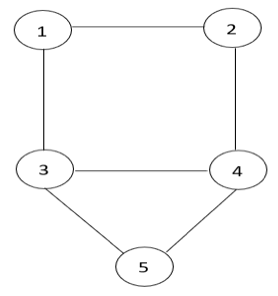

$$\text{Minimize }y=\sum_{j\in V}x_j + P\left( \sum_{(i,j)\in E}\left(1-x_i-x_j+x_ix_j\right)\right)$$

For this graph with $n=6$ and $m=5$ nodes, the model becomes:

$$
\begin{align}
\text{Minimize }y&=x_1+x_2+x_3+x_4+x_5 \\
&+ P\left( 1-x_1-x_2+x_1x_2 \right) \\
&+ P\left( 1-x_1-x_3+x_1x_3 \right) \\
&+ P\left( 1-x_2-x_4+x_2x_4 \right) \\
&+ P\left( 1-x_3-x_4+x_3x_4 \right) \\
&+ P\left( 1-x_3-x_5+x_3x_5 \right) \\
&+ P\left( 1-x_4-x_5+x_4x_5 \right) \\
\end{align}
$$

which can be written as 

$$
\begin{align}
\text{Minimize }y&=\left(1-2P\right)x_1 +
\left(1-2P\right)x_2 + 
\left(1-3P\right)x_3 +
\left(1-3P\right)x_4 + 
\left(1-2P\right)x_5 \\
&+ Px_1x_2 + Px_1x_3 + Px_2x_4 + Px_3x_5 + Px_4x_5 + 6P \\
&=\left(1-2P\right)x_1^2 +
\left(1-2P\right)x_2^2 + 
\left(1-3P\right)x_3^2 +
\left(1-3P\right)x_4^2 + 
\left(1-2P\right)x_5^2\\
&+ Px_1x_2 + Px_1x_3 + Px_2x_4 + Px_3x_5 + Px_4x_5 + 6P
\end{align}
$$

Arbitarily choosing $P=8$ and dropping the additive constant $\left( 6P=48\right)$ gives our QUBO model:

$$\text{QUBO: min}x^tQx$$

with the $Q$ matrix translated to sympy as:

In [22]:
x, P = symbols('x(:6)'), symbols('P')
x, P

((x0, x1, x2, x3, x4, x5), P)

In [23]:
# polynomial ring of symbolic coefficients
R = QQ[x[1:]+(P,)]

In [24]:
model = R(x[1]+x[2]+x[3]+x[4]+x[5]
          +P*(1-x[1]-x[2]+x[1]*x[2])
          +P*(1-x[1]-x[3]+x[1]*x[3])
          +P*(1-x[2]-x[4]+x[2]*x[4])
          +P*(1-x[3]-x[4]+x[3]*x[4])
          +P*(1-x[3]-x[5]+x[3]*x[5])
          +P*(1-x[4]-x[5]+x[4]*x[5])
         )
model

x1*x2*P + x1*x3*P - 2*x1*P + x1 + x2*x4*P - 2*x2*P + x2 + x3*x4*P + x3*x5*P - 3*x3*P + x3 + x4*x5*P - 3*x4*P + x4 - 2*x5*P + x5 + 6*P

In [25]:
Q, constant = poly_to_Q(model.subs(R(P), 8))
Q

/var/folders/cc/95f7218n54l6mb7jmsyzvssr0000gn/T/ipykernel_33071/1937982928.py:16: UserWarning: Symbol "P" was dropped from the model
  warnings.warn(f'Symbol "{str(gen)}" was dropped from the model')


tensor([[-15.,   4.,   4.,   0.,   0.],
        [  4., -15.,   0.,   4.,   0.],
        [  4.,   0., -23.,   4.,   4.],
        [  0.,   4.,   4., -23.,   4.],
        [  0.,   0.,   4.,   4., -15.]], dtype=torch.float64)

In [26]:
spins, energy = sb.minimize(Q, input_type='binary', ballistic=True)
spins, energy

Bifurcated agents: 100%|████████████████████| 128/128 [00:00<00:00, 1759.30it/s]


(tensor([1., 0., 1., 1., 0.]), -45.0)

In [27]:
y = constant + energy
y

3.0

Note that since we've ignored the additive constant, $6P=48$, during our optimization, we need to add it back to the final energy in order to get the correct value of $y = -45 + 48 = 3$

Also, notice that we add the penalty terms to the objective function (rather than subtract it) since we are minimizing the objective function. In the case where we need to maximize the objective function (see set packing below), we would subtract the penalty terms.

# The Set Packing Problem

* [See section 4.2](https://arxiv.org/pdf/1811.11538.pdf)
* See also [A new approach for modeling and solving set packing problems](https://www.researchgate.net/publication/4939938_A_new_approach_for_modeling_and_solving_set_packing_problems)

The general (traditional) formulation is given by:

$$
\begin{align}
\text{max }\sum_{j=1}^n w_jx_j \\
\text{st }\;\sum_{j=1}^na_{ij}x_j \le 1 \\
\end{align}
$$

where $a_{ij}$ are 0/1 coefficients, the $w_j$ are weights, and the $x_j$ variables are binary. Using the penalties of the form shown in the first and fifth rows of the table given earlier, we can easily construct a quadratic penalty corresponding to each of the constraints in the traditional model. Then by subtracting the penalties from the objective function, we have an unconstrained representation of the problem in the form of a QUBO model. 

# Numerical Example

$$
\begin{align}
\text{max }x_1+x_2+x_3+x_4 \\
\text{st }\;x_1\;\;\;\;+x_3+x_4 \le 1 \\
x_1+x_2\;\;\;\;\le 1
\end{align}
$$

Here all the objective function coefficients, the $w_j$ values, are equal to 1. Using the penalties mentioned above, the equivalent unconstrained problem is:

$$\text{max } x_1+x_2+x_3+x_4-Px_1x_3-Px_1x_4-Px_3x_4-Px_1x_2$$

This has our customary QUBO form:

$$\text{QUBO: max }x^tQx$$

where the $Q$ matrix, with $P$ arbitrarily chosen to be 6 (note that we split the total penalty and distribute it equally between the two corresponding off-diagonal (i.e., $i \ne j$) terms $q_{ij} = -M$ and $q_{ji} = -M$), is translated to sympy as:

In [28]:
x, P = sympy.symbols('x(:5)'), sympy.symbols('P')
x, P

((x0, x1, x2, x3, x4), P)

In [29]:
# polynomial ring of symbolic coefficients
R = QQ[x[1:]+(P,)]

In [30]:
model = R(x[1]+x[2]+x[3]+x[4]
          -P*x[1]*x[3]
          -P*x[1]*x[4]
          -P*x[3]*x[4]
          -P*x[1]*x[2]
         )
model

-x1*x2*P - x1*x3*P - x1*x4*P + x1 + x2 - x3*x4*P + x3 + x4

In [31]:
Q, constant = poly_to_Q(model.subs(R(P), 6))
Q

/var/folders/cc/95f7218n54l6mb7jmsyzvssr0000gn/T/ipykernel_33071/1937982928.py:16: UserWarning: Symbol "P" was dropped from the model
  warnings.warn(f'Symbol "{str(gen)}" was dropped from the model')


tensor([[ 1., -3., -3., -3.],
        [-3.,  1.,  0.,  0.],
        [-3.,  0.,  1., -3.],
        [-3.,  0., -3.,  1.]], dtype=torch.float64)

In [32]:
spins, energy = sb.maximize(Q, input_type='binary', ballistic=True)
spins, energy

Bifurcated agents: 100%|████████████████████| 128/128 [00:00<00:00, 1667.51it/s]


(tensor([0., 1., 1., 0.]), 2.0)

In [33]:
y = constant + energy
y

2.0

Note that unlike the MVC problem above, which is a minimization, the penalty terms are subtracted from the objective function for set packing since it is a maximization problem. Additionally, we can show that the $Q$ matrix does not have to be symmetrical as long as the coefficient for each $x_ix_j$ off-diagonal term satisfies $q_{ij}+q_{ji}=\text{coefficient}$. In other words, our $Q$ matrix will produce the exact same energy if it looked like:

In [34]:
torch.tensor([[1, -6, -6, -6],
              [0,  1,  0,  0],
              [0,  0,  1, -6],
              [0,  0,  0,  1]
            ])

tensor([[ 1, -6, -6, -6],
        [ 0,  1,  0,  0],
        [ 0,  0,  1, -6],
        [ 0,  0,  0,  1]])

Notice how this looks much more recognizable when compared with $\text{max } x_1+x_2+x_3+x_4-Px_1x_3-Px_1x_4-Px_3x_4-Px_1x_2$.
To demonstrate this further, we can gradually shift the values in the lower-left half of the symmetrical $Q$ matrix into the upper-right half of the symmetrical matrix and compare the energies with the original symmetrical $Q$ matrix and see that the energy remains the same regardless of the spins:

In [35]:
# First permute all possible spin combinations for this 4-spin system
n = Q.shape[0]
a = np.arange(n)
all_spins = []
for r in range(n+1):
    all_spins.extend([np.isin(a, x).tolist() for x in combinations(range(n), r=r)])
all_spins = np.array(all_spins) + 0

In [36]:
for spins in all_spins:
    x = np.expand_dims(spins, axis=1)
    ref = (x.T @ np.array(Q) @ x).item()
    for i in range(101):  # gradually shift the values in the lower-left half into the upper-right half in 1% increments
        Q_mod = np.tril(Q, k=-1)*(1.0 - i/100.) + np.diag(np.diag(Q)) + np.triu(Q, k=1)*(1.0 + i/100.)
        cmp = (x.T @ Q_mod @ x).item()
        npt.assert_almost_equal(ref, cmp, decimal=5)

Another similar numerical example is found in [Section 2 of this paper](https://www.researchgate.net/publication/4939938_A_new_approach_for_modeling_and_solving_set_packing_problems):

$$
\begin{align}
\text{max }2x_1+2x_2+2x_3+2x_4+4.5x_5+3x_6 \\
\text{st }x_1+x_3 \le 1 \\
x_1+x_2 \le 1 \\
x_2+x_3+x_4 \le 1 \\
x_3+x_4 \le 1 \\
x_4+x_5 \le 1 \\
x_5+x_6 \le 1
\end{align}
$$

which, along with the penalty terms, tranforms into:

$$
\begin{align}
\text{max }2x_1+2x_2+2x_3+2x_4+4.5x_5+3x_6 \\
-2Px_1x_3-2Px_1x_2-2Px_2x_3 -2Px_2x_4 -2Px_3x_4 -2Px_4x_5 -2Px_5x_6
\end{align}
$$

and translated to sympy as:

In [37]:
x, P = symbols('x(:7)'), symbols('P')
x, P

((x0, x1, x2, x3, x4, x5, x6), P)

In [38]:
# polynomial ring of symbolic coefficients
R = QQ[x[1:]+(P,)]

In [39]:
model = R(2*x[1]+2*x[2]+2*x[3]+2*x[4]+4.5*x[5]+3*x[6]
          -P*x[1]*x[3]
          -P*x[1]*x[2]
          -P*x[2]*x[3]
          -P*x[2]*x[4]
          -P*x[3]*x[4]
          -P*x[4]*x[5]
          -P*x[5]*x[6]
         )
model

-x1*x2*P - x1*x3*P + 2*x1 - x2*x3*P - x2*x4*P + 2*x2 - x3*x4*P + 2*x3 - x4*x5*P + 2*x4 - x5*x6*P + 9/2*x5 + 3*x6

In [40]:
Q, constant = poly_to_Q(model.subs(R(P), 2))
Q

/var/folders/cc/95f7218n54l6mb7jmsyzvssr0000gn/T/ipykernel_33071/1937982928.py:16: UserWarning: Symbol "P" was dropped from the model
  warnings.warn(f'Symbol "{str(gen)}" was dropped from the model')


tensor([[ 2.0000, -1.0000, -1.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  2.0000, -1.0000, -1.0000,  0.0000,  0.0000],
        [-1.0000, -1.0000,  2.0000, -1.0000,  0.0000,  0.0000],
        [ 0.0000, -1.0000, -1.0000,  2.0000, -1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -1.0000,  4.5000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -1.0000,  3.0000]],
       dtype=torch.float64)

In [41]:
spins, energy = sb.maximize(Q, input_type='binary', ballistic=True)
spins, energy

Bifurcated agents: 100%|████████████████████| 128/128 [00:00<00:00, 1784.77it/s]


(tensor([0., 1., 1., 0., 1., 1.]), 7.5)

# Establishing Satisfiability Clauses as Quadratic Penalties

See [Section 4.3](https://arxiv.org/pdf/1811.11538.pdf)

| Clause # | Clause | Quadratic Penalty | Interpretation
|---|------|-----|----|
| 1 | $x_i \lor x_j$ | $\left(1-x_i-x_j+x_ix_j\right)$ | $x_i$ OR $x_j$ (no negation)| 
| 2 | $x_i \lor \overline{x_j}$ | $\left(x_j-x_ix_j\right)$ | $x_i$ OR (NOT $x_j$) (single negation) |
| 3 | $\overline{x_i} \lor \overline{x_j}$ | $\left(x_ix_j\right)$ | (NOT $x_i$) OR (NOT $x_j$) (double negation)

Note that $x_j$ = 1 or 0 denotes whether literal j is `True` or `False` and the notation $\overline{x_j}$, the complement of $x_j$, is equal to $\left(1-x_j\right)$

# The Max 2-Sat Problem

See [Section 4.3](https://arxiv.org/pdf/1811.11538.pdf)

For a given Max 2-Sat instance then, we can add the quadratic penalties associated with the problem clauses to get a composite penalty function which we want to minimize. Since the penalties are all quadratic, this penalty function takes the form of a QUBO model:

$$min y = x^tQx$$

Moreover, if $y$ turns out to be equal to zero when minimizing the QUBO model, this means we have a solution that satisfies all of the clauses; if $y$ turns out to equal, say, 5, that means we have a solution that satisfies all but 5 of the clauses; and so forth.

# Numerical Example

The above modeling and solution procedure is illustrated by the following example with 4 variables
and 12 clauses where the penalties are determined by the clause types that need to be satisfied:

| Clause # | Clause | Quadratic Penalty |
|----------|--------|-------------------|
| 1  | $x_1 \lor x_2$ | $\left( 1-x_1-x_2+x_1x_2\right)$ |
| 2  | $x_1 \lor \overline{x_2}$ | $\left( x_2-x_1x_2\right)$ |
| 3  | $\overline{x_1} \lor x_2$ | $\left( x_1-x_1x_2\right)$ |
| 4  | $\overline{x_1} \lor \overline{x_2}$ | $\left( x_1x_2\right)$ |
| 5  | $\overline{x_1} \lor x_3$ | $\left( x_1-x_1x_3\right)$ |
| 6  | $\overline{x_1} \lor \overline{x_3}$ | $\left( x_1x_3\right)$ |
| 7  | $x_2 \lor \overline{x_3}$ | $\left( x_3-x_2x_3\right)$ |
| 8  | $x_2 \lor x_4$ | $\left( 1-x_2-x_4+x_2x_4\right)$ |
| 9  | $\overline{x_2} \lor x_3$ | $\left( x_2-x_2x_3\right)$ |
| 10 | $\overline{x_2} \lor \overline{x_3}$ | $\left( x_2x_3\right)$ |
| 11 | $x_3 \lor x_4$ | $\left( 1-x_3-x_4+x_3x_4\right)$ |
| 12 | $\overline{x_3} \lor \overline{x_4}$ | $\left( x_3x_4\right)$ |

Adding the individual clause penalties together (using SymPy):

In [42]:
x = sympy.symbols('x(:5)')
x

(x0, x1, x2, x3, x4)

In [43]:
# polynomial ring of symbolic coefficients
R = QQ[x[1:]]

In [44]:
# Define our penalties
penalties = [1-x[1]-x[2]+x[1]*x[2],
           x[2]-x[1]*x[2],
           x[1]-x[1]*x[2],
           x[1]*x[2],
           x[1]-x[1]*x[3],
           x[1]*x[3],
           x[3]-x[2]*x[3],
           1-x[2]-x[4]+x[2]*x[4],
           x[2]-x[2]*x[3],
           x[2]*x[3],
           1-x[3]-x[4]+x[3]*x[4],
           x[3]*x[4],
          ]

model = R(sympy.Add(*penalties))
model

x1 - x2*x3 + x2*x4 + 2*x3*x4 - 2*x4 + 3

gives our QUBO model:

$$\text{min } y=3+x_1-2x_4-x_2x_3+x_2x_4+2x_3x_4$$

or

$$\text{min }y=3+x^tQx$$

where the $Q$ matrix is given by:

In [45]:
Q, constant = poly_to_Q(model)
Q

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.5000,  0.5000],
        [ 0.0000, -0.5000,  0.0000,  1.0000],
        [ 0.0000,  0.5000,  1.0000, -2.0000]], dtype=torch.float64)

In [46]:
spins, energy = sb.maximize(Q, input_type='binary', ballistic=True)
spins, energy

Bifurcated agents:   0%|                                | 0/128 [00:00<?, ?it/s]
2023-10-25 12:47:08,593 - simulated_bifurcation_optimizer - WARNING - No agent has converged. Returned final positions' signs instead.


(tensor([1., 0., 1., 0.]), 1.0)

Oh, no! The simulation isn't converging so let's try decreasing the time_step to improve the likelihood of convergence:

In [47]:
sb.set_env(time_step=0.001)
spins, energy = sb.maximize(Q, input_type='binary', ballistic=True)
sb.reset_env()
spins, energy

Simulated Bifurcation optimizer's time step set to 0.001.


Bifurcated agents:   5%|█▏                      | 6/128 [00:00<00:03, 31.14it/s]


(tensor([0., 0., 0., 1.]), -2.0)

In [48]:
y = constant + energy
y

1.0

In this case, since $y=3-2=1$, this implies that all clauses except for one (i.e., 11/12 clauses) are satisfied. 

The QUBO approach illustrated above has been successfully used in [Kochenberger, et. al. (2005)](https://www.researchgate.net/publication/249874296_Using_the_unconstrained_quadratic_program_to_model_and_solve_Max_2SAT_problems) to solve Max 2-sat problems with hundreds of variables and thousands of clauses. An interesting feature of this approach for solving Max 2-sat problems is that the size of the resulting QUBO model to be solved is independent of the number of clauses in the problem and is determined only by the number of variables at hand. Thus, a Max 2-Sat problem with 200 variables and 30,000 clauses can be modeled and solved as a QUBO model with just 200 variables. 

# Creating QUBO Models: A General Purpose Approach

# The Set Partitioning Problem

See [Section 5.1](https://arxiv.org/pdf/1811.11538.pdf)

In [49]:
x, P = sympy.symbols('x(:7)'), sympy.symbols('P')
x, P

((x0, x1, x2, x3, x4, x5, x6), P)

In [50]:
# polynomial ring of symbolic coefficients
R = QQ[x[1:]+(P,)]

In [51]:
model = R(3*x[1]+2*x[2]+x[3]+x[4]+3*x[5]+2*x[6]
          +P*(x[1]+x[3]+x[6]-1)**2 + P*(x[2]+x[3]+x[5]+x[6]-1)**2
          +P*(x[3]+x[4]+x[5]-1)**2 + P*(x[1]+x[2]+x[4]+x[6]-1)**2
         )
model

2*x1**2*P + 2*x1*x2*P + 2*x1*x3*P + 2*x1*x4*P + 4*x1*x6*P - 4*x1*P + 3*x1 + 2*x2**2*P + 2*x2*x3*P + 2*x2*x4*P + 2*x2*x5*P + 4*x2*x6*P - 4*x2*P + 2*x2 + 3*x3**2*P + 2*x3*x4*P + 4*x3*x5*P + 4*x3*x6*P - 6*x3*P + x3 + 2*x4**2*P + 2*x4*x5*P + 2*x4*x6*P - 4*x4*P + x4 + 2*x5**2*P + 2*x5*x6*P - 4*x5*P + 3*x5 + 3*x6**2*P - 6*x6*P + 2*x6 + 4*P

In [52]:
Q, constant = poly_to_Q(model.subs(R(P), 10))  # Arbitrarily take P = 10
Q

/var/folders/cc/95f7218n54l6mb7jmsyzvssr0000gn/T/ipykernel_33071/1937982928.py:16: UserWarning: Symbol "P" was dropped from the model
  warnings.warn(f'Symbol "{str(gen)}" was dropped from the model')


tensor([[-17.,  10.,  10.,  10.,   0.,  20.],
        [ 10., -18.,  10.,  10.,  10.,  20.],
        [ 10.,  10., -29.,  10.,  20.,  20.],
        [ 10.,  10.,  10., -19.,  10.,  10.],
        [  0.,  10.,  20.,  10., -17.,  10.],
        [ 20.,  20.,  20.,  10.,  10., -28.]], dtype=torch.float64)

In [53]:
spins, energy = sb.minimize(Q, input_type='binary', ballistic=True)
spins, energy

Bifurcated agents: 100%|████████████████████| 128/128 [00:00<00:00, 1684.04it/s]


(tensor([1., 0., 0., 0., 1., 0.]), -34.0)

In [54]:
y = constant + energy
y

6.0

# Graph Coloring

In [55]:
for i in range(3):
    for j in range(3):
        sympy.var('a_%d%d' % (i,j))

In [56]:
a_11

a_11